# Analysis bike parkings

This analysis calculates for each city block in Barcelona how many parking spaces for bikes are within 100 meter of the block. This is compared to the number of living units (viviendas) in that block to calculate an estimate of the number of bike parking spots per person in each block. The output of this analysis is a heatmap where each city block is color coded based on the number of bike spots per person.

## Preprocessing

In [199]:
import pandas as pd
import geopandas as gpd
import json
from shapely import Point, Polygon
import matplotlib.pyplot as plt

In [200]:
# Read in data sources and set indices
js_bike_locks = json.load(open("../data/Bike_lock_spots.json"))
df_blocks = pd.read_json("../data/dades_urbanistiques_illes.json")
shp_blocks = gpd.read_file("../data/0601040100_Illes_POL_v.shp")
df_blocks.set_index("codi_illa", inplace=True)

In [201]:
# Convert the data type of the 'CODI_ILLA' column to integer to be consistent with the index of df_blocks
shp_blocks["CODI_ILLA"] = shp_blocks.loc[:,"CODI_ILLA"].astype(int)
shp_blocks.set_index("CODI_ILLA", inplace=True)

In [202]:
# Remove duplicate indices, keeping only the first occurrence
df_blocks = df_blocks[~df_blocks.index.duplicated(keep='first')]
shp_blocks = shp_blocks[~shp_blocks.index.duplicated(keep='first')]

## Analysis

In [203]:
# Results dataframe
gdf_results = gpd.GeoDataFrame(columns=["bike_locks", "living_space", "bike_locks_per_living", "geometry"], index=df_blocks.index)

In [204]:
# Create a GeoDataFrame for bike parking locations with number of locks
park_list = []
gdf_park_list = gpd.GeoDataFrame(columns = ["geometry", "locks"])
for parking in js_bike_locks["features"]:
    park_list.append({"geometry": Point(parking["properties"]["X_ETRS89"], parking["properties"]["Y_ETRS89"]), "locks": parking["properties"]["NUM_PLACES"]})
gdf_park_list = gpd.GeoDataFrame(park_list)
# This is the crs corresponding to the crs in the other data set
gdf_park_list.set_crs(epsg=25831, inplace=True)

# Replace nan values by 0, convert locks into integers
gdf_park_list["locks"] = gdf_park_list["locks"].fillna(0) 
gdf_park_list["locks"] = gdf_park_list["locks"].astype(int)

In [205]:
# Buffering for performance with distance of 100 meters
buffered_poly = shp_blocks.copy()
buffered_poly["geometry"] = buffered_poly.geometry.buffer(100)
# Spatial join of bike parking points within 100 meters of blocks
points_within_distance = gpd.sjoin(gdf_park_list, buffered_poly, how="inner", predicate='within')
df_parking_spots = points_within_distance[["locks", "CODI_ILLA"]].groupby("CODI_ILLA").sum()

In [206]:
# Fill in the results dataframe
gdf_results["bike_locks"] = df_parking_spots["locks"]
gdf_results["living_space"] = df_blocks["num_vivendes"]
gdf_results["geometry"] = shp_blocks["geometry"]
gdf_results["bike_locks_per_living"] = gdf_results["bike_locks"] / gdf_results["living_space"]
gdf_results.fillna(0, inplace=True)
gdf_results.replace(float("inf"),0, inplace=True)

## Post-processing

In [207]:
# Limit outlier values to remove extreme values from the visualization
mean = gdf_results["bike_locks_per_living"].mean()
std = gdf_results["bike_locks_per_living"].std()
gdf_results["bike_locks_per_living"] = gdf_results["bike_locks_per_living"].clip(upper=mean+3*std)

In [208]:
# Possibility to write to different file formats for CGI software
#gdf_results.to_file("../data/bike_locks_per_living_space.shp", driver="ESRI Shapefile")
#gdf_results.to_file("../data/bike_locks_per_living_space.geojson", driver="GeoJSON")

## Plotting

<Axes: title={'center': 'Bike locks per living space in city blocks of Barcelona'}>

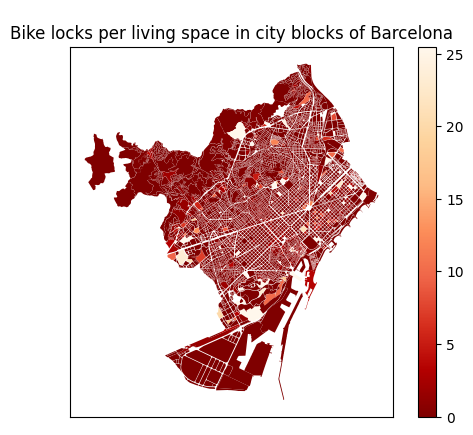

In [212]:
fig = gdf_results.plot(column="bike_locks_per_living", cmap="OrRd_r", legend=True)
fig.xaxis.set_visible(False)
fig.yaxis.set_visible(False)
fig.set_title("Bike locks per living space in city blocks of Barcelona")
plt.savefig("../figures/bike_locks_per_living_space.png", dpi=1000)
fig

In [211]:
plt.savefig("../figures/bike_locks_per_living_space.png", dpi=1000)

<Figure size 640x480 with 0 Axes>